# Load packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import yaml
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.nn import DataParallel

import numpy as np
import argparse
import time
import os
import shutil
from easydict import EasyDict as edict
from yaml import full_load

# Utils

## Loss computation

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1) # N,C,H,W => N,C,H*W
            input = input.transpose(1,2) # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2)) # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        
        if self.size_average: 
            return loss.mean()
        else: 
            return loss.sum()

## Metrics computation

In [3]:
def calcIOU(img, mask):
    sum1 = img + mask
    sum1[sum1 > 0] = 1
    sum2 = img + mask
    sum2[sum2 < 2] = 0
    sum2[sum2 >= 2] = 1
    if np.sum(sum1) == 0:
        return 1
    else:
        return 1.0 * np.sum(sum2) / np.sum(sum1)

## Logging and visualization tools

In [4]:
import tensorflow as tf
import numpy as np
# import scipy.misc

try:
    from StringIO import StringIO # Python 2.7
except ImportError:
    from io import BytesIO # Python 3.x

from PIL import Image

class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.create_file_writer(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        # summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        # self.writer.add_summary(summary, step)
        with self.writer.as_default():
            tf.summary.scalar(tag, value, step=step)
            self.writer.flush()

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        with self.writer.as_default():
            for i, img in enumerate(images):
                # Write the image to a string
                try:
                    s = StringIO()
                except:
                    s = BytesIO()
    #             scipy.misc.toimage(img).save(s, format="png")
            Image.fromarray((img*255).astype(np.uint8)).save(s,format='png')
                # Create an Image object
            #     img_sum = tf.summary.Image(encoded_image_string=s.getvalue(),
            #                                height=img.shape[0],
            #                                width=img.shape[1])
            #     # Create a Summary value
            #     img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))
            # 
            # # Create and write Summary
            # summary = tf.summary(value=img_summaries)
            # self.writer.add_summary(summary, step)
            img_str = s.getvalue()
    
            # TensorFlow 2.x 中不再使用 tf.Summary.Image，改用 tf.summary.image
            # 替换原来的 tf.Summary.Image 逻辑
            tf_image = tf.image.decode_png(img_str, channels=3)  # 将字节流解码为图片
            tf.summary.image(f'{tag}/{i}', tf.expand_dims(tf_image, 0), step=step)
            
        # TensorFlow 2.x 不再使用 tf.Summary，因此不需要创建和写入 Summary
        # summary = tf.Summary(value=img_summaries)
        # self.writer.add_summary(summary, step)
        self.writer.flush()  

    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values ** 2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        # summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        # self.writer.add_summary(summary, step)
        with self.writer.as_default():
            tf.summary.scalar(tag, hist, step=step)
            self.writer.flush()
      

# Dataset
1. Custom Dataset class(es) inheriting from torch.utils.data.Dataset
2. Data loading and preprocessing functions
3. Data augmentation techniques (if applicable)
4. Functions to split data into train/val/test sets
5. Any necessary data transformations

## Data Augmentation

In [5]:
import os
import cv2
import math
import random
import scipy
import json
import copy
import base64
import zlib
import numpy as np
from scipy.ndimage import gaussian_filter
from PIL import Image, ImageEnhance, ImageOps, ImageFile

import sys
# sys.path.insert(0, '/home/dongx12/Data/cocoapi/PythonAPI/')
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

# global parameter
set_ratio = 0.5

def load_json(fileName):
    with open(fileName,'r') as data_file:
        anno = json.load(data_file)
    return anno

def mask_to_bbox(mask):
    site = np.where(mask>0)
    bbox = [np.min(site[1]), np.min(site[0]), np.max(site[1]), np.max(site[0])]
    return bbox

# ===================== generate edge for input image =====================
def show_edge(mask_ori):
    mask = mask_ori.copy()
    # find countours: img must be binary
    myImg = np.zeros((mask.shape[0], mask.shape[1]), np.uint8)
    ret, binary = cv2.threshold(np.uint8(mask)*255, 127, 255, cv2.THRESH_BINARY)
    countours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # RETR_EXTERNAL
    '''
    cv2.drawContours(myImg, countours, -1, 1, 10)
    diff = mask + myImg
    diff[diff < 2] = 0
    diff[diff == 2] = 1
    return diff
    '''
    cv2.drawContours(myImg, countours, -1, 1, 4)
    return myImg

# ===================== load mask =====================
def annToRLE(anno, height, width):
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """
    segm = anno['segmentation']
    if isinstance(segm, list):
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, height, width)
        rle = maskUtils.merge(rles)
    elif isinstance(segm['counts'], list):
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, height, width)
    else:
        # rle
        rle = anno['segmentation']
    return rle

def annToMask(anno, height, width):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = annToRLE(anno, height, width)
    mask = maskUtils.decode(rle)
    return mask

def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.fromstring(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask

def mask_2_base64(mask):
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0,0,0,255,255,255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

# ===================== deformable data augmentation for input image =====================
def flip_data(width, keypoint_ori):
    keypoint = copy.deepcopy(keypoint_ori)
    for i in xrange(len(keypoint)/3):
        keypoint[3*i] = width - 1 - keypoint[3*i]
    right = [2,4, 6,8,10, 12,14,16]
    left  = [1,3, 5,7,9,  11,13,15]

    for i in xrange(len(left)):
        temp = copy.deepcopy(keypoint[3*right[i]:3*(right[i]+1)])
        keypoint[3*right[i]:3*(right[i]+1)] = keypoint[3*left[i]:3*(left[i]+1)]
        keypoint[3*left[i]:3*(left[i]+1)] = temp
    return keypoint

def data_aug_flip(image, mask):
    if random.random()<set_ratio:
        return image, mask, False
    return image[:,::-1,:], mask[:,::-1], True

def aug_matrix(img_w, img_h, bbox, w, h, angle_range=(-45, 45), scale_range=(0.5, 1.5), offset=40):
    '''
    first Translation, then rotate, final scale.
        [sx, 0, 0]       [cos(theta), -sin(theta), 0]       [1, 0, dx]       [x]
        [0, sy, 0] (dot) [sin(theta),  cos(theta), 0] (dot) [0, 1, dy] (dot) [y]
        [0,  0, 1]       [         0,           0, 1]       [0, 0,  1]       [1]
    '''
    ratio = 1.0*(bbox[2]-bbox[0])*(bbox[3]-bbox[1])/(img_w*img_h)
    x_offset = (random.random()-0.5) * 2 * offset
    y_offset = (random.random()-0.5) * 2 * offset
    dx = (w-(bbox[2]+bbox[0]))/2.0
    dy = (h-(bbox[3]+bbox[1]))/2.0

    matrix_trans = np.array([[1.0, 0, dx],
                             [0, 1.0, dy],
                             [0, 0,   1.0]])

    angle = random.random()*(angle_range[1]-angle_range[0])+angle_range[0]
    scale = random.random()*(scale_range[1]-scale_range[0])+scale_range[0]
    scale *= np.mean([float(w)/(bbox[2]-bbox[0]), float(h)/(bbox[3]-bbox[1])])
    alpha = scale * math.cos(angle/180.0*math.pi)
    beta = scale * math.sin(angle/180.0*math.pi)

    centerx = w/2.0 + x_offset
    centery = h/2.0 + y_offset
    H = np.array([[alpha, beta, (1-alpha)*centerx-beta*centery],
                  [-beta, alpha, beta*centerx+(1-alpha)*centery],
                  [0,         0,                            1.0]])

    H = H.dot(matrix_trans)[0:2, :]
    return H

# ===================== texture data augmentation for input image =====================
def data_aug_light(image):
    if random.random()<set_ratio:
        return image
    value = random.randint(-30, 30)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_image = np.array(hsv_image, dtype=np.float32)
    hsv_image[:,:,2] += value
    hsv_image[hsv_image>255] = 255
    hsv_image[hsv_image<0] = 0
    hsv_image = np.array(hsv_image, dtype=np.uint8)
    image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return image

def data_aug_blur(image):
    if random.random()<set_ratio:
        return image

    select = random.random()
    if select < 0.3:
        kernalsize = random.choice([3,5])
        image = cv2.GaussianBlur(image, (kernalsize,kernalsize),0)
    elif select < 0.6:
        kernalsize = random.choice([3,5])
        image = cv2.medianBlur(image, kernalsize)
    else:
        kernalsize = random.choice([3,5])
        image = cv2.blur(image, (kernalsize,kernalsize))
    return image

def data_aug_color(image):
    if random.random()<set_ratio:
        return image
    random_factor = np.random.randint(4, 17) / 10.
    color_image = ImageEnhance.Color(image).enhance(random_factor)
    random_factor = np.random.randint(4, 17) / 10.
    brightness_image = ImageEnhance.Brightness(color_image).enhance(random_factor)
    random_factor = np.random.randint(6, 15) / 10.
    contrast_image = ImageEnhance.Contrast(brightness_image).enhance(random_factor)
    random_factor = np.random.randint(8, 13) / 10.
    return ImageEnhance.Sharpness(contrast_image).enhance(random_factor)

def data_aug_noise(image):
    if random.random()<set_ratio:
        return image
    mu = 0
    sigma = random.random()*10.0
    image = np.array(image, dtype=np.float32)
    image += np.random.normal(mu, sigma, image.shape)
    image[image>255] = 255
    image[image<0] = 0
    return image

# ===================== normalization for input image =====================
def padding(img_ori, mask_ori, size=224, padding_color=128):
    height = img_ori.shape[0]
    width = img_ori.shape[1]

    img = np.zeros((max(height, width), max(height, width), 3)) + padding_color
    mask = np.zeros((max(height, width), max(height, width)))

    if (height > width):
        padding = int((height-width)/2)
        img[:, padding:padding+width, :] = img_ori
        mask[:, padding:padding+width] = mask_ori
    else:
        padding = int((width-height)/2)
        img[padding:padding+height, :, :] = img_ori
        mask[padding:padding+height, :] = mask_ori

    img = np.uint8(img)
    mask = np.uint8(mask)

    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_CUBIC)

    return np.array(img, dtype=np.float32),  np.array(mask, dtype=np.float32)

def Normalize_Img(imgOri, scale, mean, val):
    img = np.array(imgOri.copy(), np.float32)/scale
    if len(img.shape) == 4:
        for j in range(img.shape[0]):
            for i in range(len(mean)):
                img[j,:,:,i] = (img[j,:,:,i]-mean[i])*val[i]
        return img
    else:
        for i in range(len(mean)):
            img[:,:,i] = (img[:,:,i]-mean[i])*val[i]
        return img

def Anti_Normalize_Img(imgOri, scale, mean, val):
    img = np.array(imgOri.copy(), np.float32)
    if len(img.shape) == 4:
        for j in range(img.shape[0]):
            for i in range(len(mean)):
                img[j,:,:,i] = img[j,:,:,i]/val[i]+mean[i]
        return np.array(img*scale, np.uint8)
    else:
        for i in range(len(mean)):
            img[:,:,i] = img[:,:,i]/val[i]+mean[i]
        return np.array(img*scale, np.uint8)

# ===================== generate prior channel for input image =====================
def data_motion_blur(image, mask):
    if random.random()<set_ratio:
        return image, mask

    degree = random.randint(5, 30)
    angle = random.randint(0, 360)

    M = cv2.getRotationMatrix2D((degree/2, degree/2), angle, 1)
    motion_blur_kernel = np.diag(np.ones(degree))
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (degree, degree))
    motion_blur_kernel = motion_blur_kernel/degree

    img_blurred = cv2.filter2D(image, -1, motion_blur_kernel)
    mask_blurred = cv2.filter2D(mask, -1, motion_blur_kernel)

    cv2.normalize(img_blurred, img_blurred, 0, 255, cv2.NORM_MINMAX)
    cv2.normalize(mask_blurred, mask_blurred, 0, 1, cv2.NORM_MINMAX)
    return img_blurred, mask_blurred

def data_motion_blur_prior(prior):
    if random.random()<set_ratio:
        return prior

    degree = random.randint(5, 30)
    angle = random.randint(0, 360)

    M = cv2.getRotationMatrix2D((degree/2, degree/2), angle, 1)
    motion_blur_kernel = np.diag(np.ones(degree))
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (degree, degree))
    motion_blur_kernel = motion_blur_kernel/degree

    prior_blurred = cv2.filter2D(prior, -1, motion_blur_kernel)
    return prior_blurred

def data_Affine(image, mask, height, width, ratio=0.05):
    if random.random()<set_ratio:
        return image, mask
    bias = np.random.randint(-int(height*ratio),int(width*ratio), 12)
    pts1 = np.float32([[0+bias[0], 0+bias[1]], [width+bias[2], 0+bias[3]], [0+bias[4], height+bias[5]]])
    pts2 = np.float32([[0+bias[6], 0+bias[7]], [width+bias[8], 0+bias[9]], [0+bias[10], height+bias[11]]])
    M = cv2.getAffineTransform(pts1, pts2)
    img_affine = cv2.warpAffine(image, M, (width, height))
    mask_affine = cv2.warpAffine(mask, M, (width, height))
    return img_affine, mask_affine

def data_Affine_prior(prior, height, width, ratio=0.05):
    if random.random()<set_ratio:
        return prior
    bias = np.random.randint(-int(height*ratio),int(width*ratio), 12)
    pts1 = np.float32([[0+bias[0], 0+bias[1]], [width+bias[2], 0+bias[3]], [0+bias[4], height+bias[5]]])
    pts2 = np.float32([[0+bias[6], 0+bias[7]], [width+bias[8], 0+bias[9]], [0+bias[10], height+bias[11]]])
    M = cv2.getAffineTransform(pts1, pts2)
    prior_affine = cv2.warpAffine(prior, M, (width, height))
    return prior_affine

def data_Perspective(image, mask, height, width, ratio=0.05):
    if random.random()<set_ratio:
        return image, mask
    bias = np.random.randint(-int(height*ratio),int(width*ratio), 16)
    pts1 = np.float32([[0+bias[0],0+bias[1]], [height+bias[2],0+bias[3]],
                       [0+bias[4],width+bias[5]], [height+bias[6], width+bias[7]]])
    pts2 = np.float32([[0+bias[8],0+bias[9]], [height+bias[10],0+bias[11]],
                       [0+bias[12],width+bias[13]], [height+bias[14], width+bias[15]]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    img_perspective = cv2.warpPerspective(image, M, (width, height))
    mask_perspective = cv2.warpPerspective(mask, M, (width, height))
    return img_perspective, mask_perspective

def data_Perspective_prior(prior, height, width, ratio=0.05):
    if random.random()<set_ratio:
        return prior
    bias = np.random.randint(-int(height*ratio),int(width*ratio), 16)
    pts1 = np.float32([[0+bias[0],0+bias[1]], [height+bias[2],0+bias[3]],
                       [0+bias[4],width+bias[5]], [height+bias[6], width+bias[7]]])
    pts2 = np.float32([[0+bias[8],0+bias[9]], [height+bias[10],0+bias[11]],
                       [0+bias[12],width+bias[13]], [height+bias[14], width+bias[15]]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    prior_perspective = cv2.warpPerspective(prior, M, (width, height))
    return prior_perspective

def data_ThinPlateSpline(image, mask, height, width, ratio=0.05):
    if random.random()<set_ratio:
        return image, mask
    bias = np.random.randint(-int(height*ratio),int(width*ratio), 16)
    tps = cv2.createThinPlateSplineShapeTransformer()
    sshape = np.array([[0+bias[0],0+bias[1]], [height+bias[2],0+bias[3]],
                       [0+bias[4],width+bias[5]], [height+bias[6], width+bias[7]]], np.float32)
    tshape = np.array([[0+bias[8],0+bias[9]], [height+bias[10],0+bias[11]],
                       [0+bias[12],width+bias[13]], [height+bias[14], width+bias[15]]], np.float32)
    sshape = sshape.reshape(1,-1,2)
    tshape = tshape.reshape(1,-1,2)
    matches = list()
    matches.append(cv2.DMatch(0,0,0))
    matches.append(cv2.DMatch(1,1,0))
    matches.append(cv2.DMatch(2,2,0))
    matches.append(cv2.DMatch(3,3,0))

    tps.estimateTransformation(tshape, sshape, matches)
    res = tps.warpImage(image)
    res_mask = tps.warpImage(mask)
    return res, res_mask

def data_ThinPlateSpline_prior(prior, height, width, ratio=0.05):
    if random.random()<set_ratio:
        return prior
    bias = np.random.randint(-int(height*ratio),int(width*ratio), 16)
    tps = cv2.createThinPlateSplineShapeTransformer()
    sshape = np.array([[0+bias[0],0+bias[1]], [height+bias[2],0+bias[3]],
                       [0+bias[4],width+bias[5]], [height+bias[6], width+bias[7]]], np.float32)
    tshape = np.array([[0+bias[8],0+bias[9]], [height+bias[10],0+bias[11]],
                       [0+bias[12],width+bias[13]], [height+bias[14], width+bias[15]]], np.float32)
    sshape = sshape.reshape(1,-1,2)
    tshape = tshape.reshape(1,-1,2)
    matches = list()
    matches.append(cv2.DMatch(0,0,0))
    matches.append(cv2.DMatch(1,1,0))
    matches.append(cv2.DMatch(2,2,0))
    matches.append(cv2.DMatch(3,3,0))

    tps.estimateTransformation(tshape, sshape, matches)
    prior = tps.warpImage(prior)
    return prior

## Datasets Portrait Segmentation

In [6]:
import torch
import torch.utils.data as data

import os
import cv2
import sys
import numpy as np
import math
import random
import scipy
from scipy.ndimage import gaussian_filter
from easydict import EasyDict as edict

import json
import time
import copy
from PIL import Image
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# from data_aug import data_aug_blur, data_aug_color, data_aug_noise, data_aug_light
# from data_aug import data_aug_flip, flip_data, aug_matrix
# from data_aug import show_edge, mask_to_bbox, load_json
# from data_aug import base64_2_mask, mask_2_base64, padding, Normalize_Img, Anti_Normalize_Img
# from data_aug import data_motion_blur, data_Affine, data_Perspective, data_ThinPlateSpline
# from data_aug import data_motion_blur_prior, data_Affine_prior, data_Perspective_prior, data_ThinPlateSpline_prior

class PortraitSeg(data.Dataset):
    def __init__(self, ImageRoot, AnnoRoot, ImgIds_Train, ImgIds_Test, exp_args):
        self.ImageRoot = ImageRoot
        self.AnnoRoot = AnnoRoot
        self.istrain = exp_args.istrain
        self.stability = exp_args.stability
        self.addEdge = exp_args.addEdge

        self.video = exp_args.video
        self.prior_prob = exp_args.prior_prob

        self.task = exp_args.task
        self.dataset = exp_args.dataset #eg1800
        self.input_height = exp_args.input_height
        self.input_width = exp_args.input_width

        self.padding_color = exp_args.padding_color
        self.img_scale = exp_args.img_scale
        self.img_mean = exp_args.img_mean # BGR order
        self.img_val = exp_args.img_val # BGR order

        if self.istrain == True:
            file_object = open(ImgIds_Train, 'r')
        elif self.istrain == False:
            file_object = open(ImgIds_Test, 'r')

        try:
            self.imgIds = file_object.readlines() #1447
            if self.dataset == "MscocoBackground" and self.istrain == True:
                self.imgIds = self.imgIds[:5000]

            if self.dataset == "ATR" and self.istrain == True:
                self.imgIds = self.imgIds[:5000]

            # if self.istrain == False:
            #     self.imgIds = self.imgIds[:100]

        finally:
             file_object.close()
        pass


    def __getitem__(self, index):
        '''
        An item is an image. Which may contains more than one person.
        '''
        img = None
        mask = None
        bbox = None
        H = None

        if self.dataset == "supervisely":
            # basic info
            img_path = os.path.join(self.ImageRoot, self.imgIds[index].strip())
            img_name = img_path[img_path.rfind('/')+1:]
            img = cv2.imread(img_path)

            # load mask
            annopath = img_path.replace('/img/', '/ann/')
            annopath = annopath[:annopath.find('.')]+'.json'
            ann = load_json(annopath)
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
            for i in range(len(ann['objects'])):
                mask_temp = np.zeros((img.shape[0], img.shape[1]))
                if ann['objects'][i]['classTitle'] == 'person_poly':
                    points = np.array(ann['objects'][i]['points']['exterior'])
                    if len(points) > 0:
                        cv2.fillPoly(mask_temp, [points], 1)
                        points = np.array(ann['objects'][i]['points']['interior'])
                        for p in points:
                            cv2.fillPoly(mask_temp, [np.array(p)], 0)
                elif ann['objects'][i]['classTitle'] == 'neutral':
                    points = np.array(ann['objects'][i]['points']['exterior'])
                    if len(points) > 0:
                        cv2.fillPoly(mask_temp, [points], 1)
                        points = np.array(ann['objects'][i]['points']['interior'])
                        for p in points:
                            cv2.fillPoly(mask_temp, [np.array(p)], 0)
                elif ann['objects'][i]['classTitle'] == 'person_bmp':
                    data = np.array(ann['objects'][i]['bitmap']['data'])
                    if data.size > 0:
                        mask_ = base64_2_mask(data)
                        origin = ann['objects'][i]['bitmap']['origin']
                        mask_temp[origin[1]:origin[1]+mask_.shape[0], origin[0]:origin[0]+mask_.shape[1]] = mask_
                mask[mask_temp>0] = 1

            height, width, channel = img.shape
            # bbox = mask_to_bbox(mask)
            bbox = [0, 0, width-1, height-1]

            H = aug_matrix(width, height, bbox, self.input_width, self.input_height,
                       angle_range=(-45, 45), scale_range=(0.5, 1.5), offset=self.input_height/4)

        elif self.dataset in ["supervisely_face_easy", "supervisely_face_difficult"]:
            # basic info
            img_path = os.path.join(self.ImageRoot, self.imgIds[index].strip())
            img_name = img_path[img_path.rfind('/')+1:]
            img = cv2.imread(img_path)
            # img = cv2.imread(img_path.replace('/img/', '/imgAug/'))

            # load mask
            annopath = img_path.replace('/img/', '/ann/')
            # annopath = img_path.replace('/img/', '/maskAug/')

            mask = cv2.imread(annopath, 0) # origin mask = 255
            mask[mask>0] = 1

            height, width, channel = img.shape
            # bbox = mask_to_bbox(mask)
            bbox = [0, 0, width-1, height-1]
            H = aug_matrix(width, height, bbox, self.input_width, self.input_height,
                       angle_range=(-45, 45), scale_range=(0.5, 1.5), offset=self.input_height/4)

        elif self.dataset in ["flickr", "eg1800", "liveshow"]:
            # basic info
            img_id = self.imgIds[index].strip()
            img_path = os.path.join(self.ImageRoot, img_id)
            img = cv2.imread(img_path)
            # img = cv2.imread(img_path.replace('Images', 'ImagesAug'))
            img_name = img_path[img_path.rfind('/')+1:]

            # load mask
            annopath = os.path.join(self.AnnoRoot, img_id.replace('.jpg', '.png'))
            mask = cv2.imread(annopath, 0)
            # mask = cv2.imread(annopath.replace('Labels', 'LabelsAug'), 0)
            mask[mask>1] = 0

            height, width, channel = img.shape
            bbox = [0, 0, width-1, height-1]
            H = aug_matrix(width, height, bbox, self.input_width, self.input_height,
                       angle_range=(-45, 45), scale_range=(0.5, 1.5), offset=self.input_height/4)

        elif self.dataset == "ATR":
            # basic info
            img_id = self.imgIds[index].strip()
            img_path = os.path.join(self.ImageRoot, img_id)
            img = cv2.imread(img_path)
            img_name = img_path[img_path.rfind('/')+1:]

            # load mask
            annopath = os.path.join(self.AnnoRoot, img_id.replace('.jpg', '.png'))
            mask = cv2.imread(annopath, 0)
            mask[mask>1] = 1

            height, width, channel = img.shape
            bbox = [0, 0, width-1, height-1]
            H = aug_matrix(width, height, bbox, self.input_width, self.input_height,
                       angle_range=(-45, 45), scale_range=(0.5, 1.5), offset=self.input_height/4)

        elif self.dataset == "MscocoBackground":
            # basic info
            img_path = self.imgIds[index].strip()
            img_path = os.path.join(self.ImageRoot, img_path)
            img = cv2.imread(img_path)
            height, width, channel = img.shape
            mask = np.zeros((height, width))

            bbox = [0, 0, width-1, height-1]
            H = aug_matrix(width, height, bbox, self.input_width, self.input_height,
                       angle_range=(-45, 45), scale_range=(1.5, 2.0), offset=self.input_height/4)

        use_float_mask = False # use original 0/1 mask as groundtruth

        # data augument: first align center to center of dst size. then rotate and scale
        if self.istrain == False:
            img_aug_ori, mask_aug_ori = padding(img, mask, size=self.input_width, padding_color=self.padding_color)

            # ===========add new channel for video stability============
            input_norm = Normalize_Img(img_aug_ori, scale=self.img_scale, mean=self.img_mean, val=self.img_val)
            if self.video == True:
                prior = np.zeros((self.input_height, self.input_width, 1))
                input_norm = np.c_[input_norm, prior]
            input = np.transpose(input_norm, (2, 0, 1))
            input_ori = copy.deepcopy(input)
        else:
            img_aug = cv2.warpAffine(np.uint8(img), H, (self.input_width, self.input_height),
                                     flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                     borderValue=(self.padding_color, self.padding_color, self.padding_color))
            mask_aug = cv2.warpAffine(np.uint8(mask), H, (self.input_width, self.input_height),
                                      flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT)
            img_aug_ori, mask_aug_ori, aug_flag = data_aug_flip(img_aug, mask_aug)
            prior = np.zeros((self.input_height, self.input_width, 1))

            # ======== add new channel for video stability =========
            if self.video == True and self.prior_prob >= random.random(): # add new augmentation
                prior[:,:,0] = mask_aug_ori.copy()
                prior = np.array(prior, dtype=np.float)

                if random.random() >= 0.5:
                    # modify image + mask, use groundtruth as prior
                    img_aug_ori = np.array(img_aug_ori)
                    mask_aug_ori = np.array(mask_aug_ori, dtype=np.float)
                    img_aug_ori, mask_aug_ori = data_motion_blur(img_aug_ori, mask_aug_ori)
                    img_aug_ori, mask_aug_ori = data_Affine(img_aug_ori, mask_aug_ori, self.input_height, self.input_width, ratio=0.05)
                    img_aug_ori, mask_aug_ori = data_Perspective(img_aug_ori, mask_aug_ori, self.input_height, self.input_width, ratio=0.05)
                    img_aug_ori, mask_aug_ori = data_ThinPlateSpline(img_aug_ori, mask_aug_ori, self.input_height, self.input_width, ratio=0.05)
                    use_float_mask = True
                else:
                    # modify prior, don't change image + mask
                    prior = data_motion_blur_prior(prior)
                    prior = data_Affine_prior(prior, self.input_height, self.input_width, ratio=0.05)
                    prior = data_Perspective_prior(prior, self.input_height, self.input_width, ratio=0.05)
                    prior = data_ThinPlateSpline_prior(prior, self.input_height, self.input_width, ratio=0.05)
                    prior = prior.reshape(self.input_height, self.input_width, 1)

            # add augmentation
            img_aug = Image.fromarray(cv2.cvtColor(img_aug_ori, cv2.COLOR_BGR2RGB))
            img_aug = data_aug_color(img_aug)
            img_aug = np.asarray(img_aug)
            # img_aug = data_aug_light(img_aug)
            img_aug = data_aug_blur(img_aug)
            img_aug = data_aug_noise(img_aug)
            img_aug = np.float32(img_aug[:,:,::-1]) # BGR, like cv2.imread

            input_norm = Normalize_Img(img_aug, scale=self.img_scale, mean=self.img_mean, val=self.img_val)
            input_ori_norm = Normalize_Img(img_aug_ori, scale=self.img_scale, mean=self.img_mean, val=self.img_val)

            if self.video == True:
                input_norm = np.c_[input_norm, prior]
                input_ori_norm = np.c_[input_ori_norm, prior]

            input = np.transpose(input_norm, (2, 0, 1))
            input_ori = np.transpose(input_ori_norm, (2, 0, 1))

        if 'seg' in self.task:
            if use_float_mask == True:
                output_mask = cv2.resize(mask_aug_ori, (self.input_width, self.input_height), interpolation=cv2.INTER_NEAREST)
                cv2.normalize(output_mask, output_mask, 0, 1, cv2.NORM_MINMAX)
                output_mask[output_mask>=0.5] = 1
                output_mask[output_mask<0.5] = 0
            else:
                output_mask = cv2.resize(np.uint8(mask_aug_ori), (self.input_width, self.input_height), interpolation=cv2.INTER_NEAREST)

                # add mask blur
                output_mask = np.uint8(cv2.blur(output_mask, (5,5)))
                output_mask[output_mask>=0.5] = 1
                output_mask[output_mask<0.5] = 0
        else:
            output_mask = np.zeros((self.input_height, self.input_width), dtype=np.uint8) + 255

        if self.task == 'seg':
            edge = show_edge(output_mask)
            # edge_blur = np.uint8(cv2.blur(edge, (5,5)))/255.0
            return input_ori, input, edge, output_mask

    def __len__(self):
        return len(self.imgIds)

## Datasets

In [7]:
import torch
import torch.utils.data as data
import numpy as np

# from datasets_portraitseg import PortraitSeg

class Human(data.Dataset):
    def __init__(self, exp_args):
        assert exp_args.task in ['seg'], 'Error!, <task> should in [seg]'

        self.exp_args = exp_args
        self.task = exp_args.task
        self.datasetlist = exp_args.datasetlist #['EG1800']
        self.data_root = exp_args.data_root # data_root = '/home/dongx12/Data/'
        #/home/liuchang/portraitNet/PortraitNet-master/Data/
        self.file_root = exp_args.file_root # file_root = '/home/dongx12/PortraitNet/data/select_data/'
        #/home/liuchang/portraitNet/PortraitNet-master/data/select_data/
        self.datasets = {}
        self.imagelist = []

        # load dataset
        if 'supervisely' in self.datasetlist:
            ImageRoot = self.data_root
            AnnoRoot = self.data_root
            ImgIds_Train = self.file_root + 'supervisely_train_new.txt'
            ImgIds_Test = self.file_root + 'supervisely_test_new.txt'
            exp_args.dataset = 'supervisely'
            self.datasets['supervisely'] = PortraitSeg(ImageRoot, AnnoRoot, ImgIds_Train, ImgIds_Test, self.exp_args)

        if 'EG1800' in self.datasetlist:
            ImageRoot = self.data_root + 'EG1800/Images/'
            AnnoRoot = self.data_root + 'EG1800/Labels/'
            ImgIds_Train = self.file_root + 'eg1800_train.txt'
            ImgIds_Test = self.file_root + 'eg1800_test.txt'
            exp_args.dataset = 'eg1800'
            self.datasets['eg1800'] = PortraitSeg(ImageRoot, AnnoRoot, ImgIds_Train, ImgIds_Test, self.exp_args)
        
        if 'matting_human_sample' in self.datasetlist:
            ImageRoot = self.data_root + 'matting_human_sample/clip_img/'
            AnnoRoot = self.data_root + 'matting_human_sample/matting/'
            ImgIds_Train = self.file_root + 'matting_human_sample_train.txt'
            ImgIds_Test = self.file_root + 'matting_human_sample_test.txt'
            exp_args.dataset = 'matting_human_sample'
            self.datasets['matting_human_sample'] = PortraitSeg(ImageRoot, AnnoRoot, ImgIds_Train, ImgIds_Test, self.exp_args)
        
        if 'ATR' in self.datasetlist:
            ImageRoot = self.data_root + 'ATR/train/images/'
            AnnoRoot = self.data_root + 'ATR/train/seg/'
            ImgIds_Train = self.file_root + 'ATR_train.txt'
            ImgIds_Test = self.file_root + 'ATR_test.txt'
            exp_args.dataset = 'ATR'
            self.datasets['ATR'] = PortraitSeg(ImageRoot, AnnoRoot, ImgIds_Train, ImgIds_Test, self.exp_args)

        if 'supervisely_face_easy' in self.datasetlist:
            ImageRoot = self.data_root
            AnnoRoot = self.data_root
            ImgIds_Train = self.file_root + 'supervisely_face_train_easy.txt'
            ImgIds_Test = self.file_root + 'supervisely_face_test_easy.txt'
            exp_args.dataset = 'supervisely_face_easy'
            self.datasets['supervisely_face_easy'] = PortraitSeg(ImageRoot, AnnoRoot, ImgIds_Train, ImgIds_Test, self.exp_args)

        if 'supervisely_face_difficult' in self.datasetlist:
            ImageRoot = self.data_root
            AnnoRoot = self.data_root
            ImgIds_Train = self.file_root + 'supervisely_face_train_difficult.txt'
            ImgIds_Test = self.file_root + 'supervisely_face_test_difficult.txt'
            exp_args.dataset = 'supervisely_face_difficult'
            self.datasets['supervisely_face_difficult'] = PortraitSeg(ImageRoot, AnnoRoot, ImgIds_Train, ImgIds_Test, self.exp_args)

        if 'MscocoBackground' in self.datasetlist:
            dataType = 'train2017'
            ImageRoot = self.data_root
            AnnoRoot = self.data_root + 'mscoco2017/annotations/person_keypoints_{}.json'.format(dataType)
            ImgIds_Train = self.file_root + 'select_mscoco_background_train2017.txt'
            ImgIds_Test = self.file_root + 'select_mscoco_background_val2017.txt'
            exp_args.dataset = 'MscocoBackground'
            self.datasets['background'] = PortraitSeg(ImageRoot, AnnoRoot, ImgIds_Train, ImgIds_Test, self.exp_args)


        # image list
        for key in self.datasets.keys():
            length = len(self.datasets[key])
            for i in range(length): # eg1800 1447
                self.imagelist.append([key, i])

    def __getitem__(self, index):
        subset, subsetidx = self.imagelist[index]

        if self.task == 'seg':
            input_ori, input, output_edge, output_mask = self.datasets[subset][subsetidx]
            return input_ori.astype(np.float32), input.astype(np.float32), \
        output_edge.astype(np.int64), output_mask.astype(np.int64)

    def __len__(self):
        return len(self.imagelist)

# Portraitnet

## model

In [8]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.models as models
from torch.autograd import Variable

import numpy as np
  
def make_bilinear_weights(size, num_channels):
    ''' Make a 2D bilinear kernel suitable for upsampling
    Stack the bilinear kernel for application to tensor '''
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)

    # print filt
    filt = torch.from_numpy(filt)
    w = torch.zeros(num_channels, 1, size, size)
    for i in range(num_channels):
        w[i, 0] = filt
    return w    
    
# 1x1 Convolution
def conv_1x1(inp, oup):
    """1x1 convolution with padding"""
    return nn.Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, stride=1, padding=0, bias=False)

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(num_features=oup, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True)
    )

def conv_bn(inp, oup, kernel, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels=inp, out_channels=oup, kernel_size=kernel, stride=stride, padding=int((kernel-1)/2), bias=False),
        nn.BatchNorm2d(num_features=oup, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, kernel, stride):
    return nn.Sequential(
        nn.Conv2d(inp, inp, kernel, stride, int((kernel-1)/2), groups=inp, bias=False),
        nn.BatchNorm2d(num_features=inp, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(num_features=oup, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, dilation=1):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]
        self.use_res_connect = self.stride == 1 and inp == oup

        self.conv = nn.Sequential(
            # pw
            nn.Conv2d(inp, inp * expand_ratio, kernel_size=1, stride=1, padding=0, dilation=1, groups=1, bias=False),
            nn.BatchNorm2d(num_features=inp * expand_ratio, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            # dw
            nn.Conv2d(inp * expand_ratio, inp * expand_ratio, 
                      kernel_size=3, stride=stride, padding=dilation, dilation=dilation,
                      groups=inp * expand_ratio, bias=False),
            nn.BatchNorm2d(num_features=inp * expand_ratio, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            # pw-linear
            nn.Conv2d(inp * expand_ratio, oup, kernel_size=1, stride=1, padding=0, dilation=1, groups=1, bias=False),
            nn.BatchNorm2d(num_features=oup, eps=1e-05, momentum=0.1, affine=True),
        )
        
    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)
        
        
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, inp, oup, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            conv_dw(inp, oup, 3, stride=stride),
            nn.Conv2d(in_channels=oup, out_channels=oup, kernel_size=3, stride=1, padding=1, groups=oup, bias=False),
            nn.BatchNorm2d(num_features=oup, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=oup, out_channels=oup, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=oup, eps=1e-05, momentum=0.1, affine=True),
        )
        if inp == oup:
            self.residual = None
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(num_features=oup, eps=1e-05, momentum=0.1, affine=True),
            )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = x
        
        out = self.block(x)
        if self.residual is not None:
            residual = self.residual(x)
            
        out += residual
        out = self.relu(out)
        return out
    
    
class MobileNetV2(nn.Module):
    def __init__(self, n_class=2, useUpsample=False, useDeconvGroup=False, addEdge=False, 
                 channelRatio=1.0, minChannel=16, weightInit=True, video=False):
        super(MobileNetV2, self).__init__()
        '''
        # setting of inverted residual blocks
        self.interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        '''
        self.addEdge = addEdge
        self.channelRatio = channelRatio
        self.minChannel = minChannel
        self.useDeconvGroup = useDeconvGroup
        
        if video == True:
            self.stage0 = conv_bn(4, self.depth(32), 3, 2)
        else:
            self.stage0 = conv_bn(3, self.depth(32), 3, 2)
        
        self.stage1 = InvertedResidual(self.depth(32), self.depth(16), 1, 1) # 1/2
        
        self.stage2 = nn.Sequential( # 1/4
            InvertedResidual(self.depth(16), self.depth(24), 2, 6),
            InvertedResidual(self.depth(24), self.depth(24), 1, 6),
        )
        
        self.stage3 = nn.Sequential( # 1/8
            InvertedResidual(self.depth(24), self.depth(32), 2, 6),
            InvertedResidual(self.depth(32), self.depth(32), 1, 6),
            InvertedResidual(self.depth(32), self.depth(32), 1, 6),
        )
        
        self.stage4 = nn.Sequential( # 1/16
            InvertedResidual(self.depth(32), self.depth(64), 2, 6),
            InvertedResidual(self.depth(64), self.depth(64), 1, 6),
            InvertedResidual(self.depth(64), self.depth(64), 1, 6),
            InvertedResidual(self.depth(64), self.depth(64), 1, 6),
        )
        
        self.stage5 = nn.Sequential( # 1/16
            InvertedResidual(self.depth(64), self.depth(96), 1, 6),
            InvertedResidual(self.depth(96), self.depth(96), 1, 6),
            InvertedResidual(self.depth(96), self.depth(96), 1, 6),
        )
        
        self.stage6 = nn.Sequential( # 1/32
            InvertedResidual(self.depth(96), self.depth(160), 2, 6),
            InvertedResidual(self.depth(160), self.depth(160), 1, 6),
            InvertedResidual(self.depth(160), self.depth(160), 1, 6),
        )
        
        self.stage7 = InvertedResidual(self.depth(160), self.depth(320), 1, 6) # 1/32
        
        
        if useUpsample == True:
            self.deconv1 = nn.Upsample(scale_factor=2, mode='bilinear')
            self.deconv2 = nn.Upsample(scale_factor=2, mode='bilinear')
            self.deconv3 = nn.Upsample(scale_factor=2, mode='bilinear')    
            self.deconv4 = nn.Upsample(scale_factor=2, mode='bilinear')
            self.deconv5 = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            if useDeconvGroup == True:
                self.deconv1 = nn.ConvTranspose2d(self.depth(96), self.depth(96), groups=self.depth(96), 
                                                  kernel_size=4, stride=2, padding=1, bias=False)
                self.deconv2 = nn.ConvTranspose2d(self.depth(32), self.depth(32), groups=self.depth(32), 
                                                  kernel_size=4, stride=2, padding=1, bias=False)
                self.deconv3 = nn.ConvTranspose2d(self.depth(24), self.depth(24), groups=self.depth(24), 
                                                  kernel_size=4, stride=2, padding=1, bias=False)
                self.deconv4 = nn.ConvTranspose2d(self.depth(16), self.depth(16), groups=self.depth(16), 
                                                  kernel_size=4, stride=2, padding=1, bias=False)
                self.deconv5 = nn.ConvTranspose2d(self.depth(8),  self.depth(8),  groups=self.depth(8),  
                                                  kernel_size=4, stride=2, padding=1, bias=False)
            else:
                self.deconv1 = nn.ConvTranspose2d(self.depth(96), self.depth(96), 
                                                  groups=1, kernel_size=4, stride=2, padding=1, bias=False)
                self.deconv2 = nn.ConvTranspose2d(self.depth(32), self.depth(32), 
                                                  groups=1, kernel_size=4, stride=2, padding=1, bias=False)
                self.deconv3 = nn.ConvTranspose2d(self.depth(24), self.depth(24), 
                                                  groups=1, kernel_size=4, stride=2, padding=1, bias=False)
                self.deconv4 = nn.ConvTranspose2d(self.depth(16), self.depth(16), 
                                                  groups=1, kernel_size=4, stride=2, padding=1, bias=False)
                self.deconv5 = nn.ConvTranspose2d(self.depth(8),  self.depth(8),  
                                                  groups=1, kernel_size=4, stride=2, padding=1, bias=False)
        
        self.transit1 = ResidualBlock(self.depth(320), self.depth(96))
        self.transit2 = ResidualBlock(self.depth(96),  self.depth(32))
        self.transit3 = ResidualBlock(self.depth(32),  self.depth(24))
        self.transit4 = ResidualBlock(self.depth(24),  self.depth(16))
        self.transit5 = ResidualBlock(self.depth(16),  self.depth(8))
        
        self.pred = nn.Conv2d(self.depth(8), n_class, 3, 1, 1, bias=False)
        if self.addEdge == True:
            self.edge = nn.Conv2d(self.depth(8), n_class, 3, 1, 1, bias=False)
        
        if weightInit == True:
            self._initialize_weights()
            
    def depth(self, channels):
        min_channel = min(channels, self.minChannel)
        return max(min_channel, int(channels*self.channelRatio))
    
    def forward(self, x):
        feature_1_2  = self.stage0(x)
        feature_1_2  = self.stage1(feature_1_2)
        feature_1_4  = self.stage2(feature_1_2)
        feature_1_8  = self.stage3(feature_1_4)
        feature_1_16 = self.stage4(feature_1_8)
        feature_1_16 = self.stage5(feature_1_16)
        feature_1_32 = self.stage6(feature_1_16)
        feature_1_32 = self.stage7(feature_1_32)
        
        up_1_16 = self.deconv1(self.transit1(feature_1_32))
        up_1_8  = self.deconv2(self.transit2(feature_1_16 + up_1_16))
        up_1_4  = self.deconv3(self.transit3(feature_1_8 + up_1_8))
        up_1_2  = self.deconv4(self.transit4(feature_1_4 + up_1_4))
        up_1_1  = self.deconv5(self.transit5(up_1_2))
        
        pred = self.pred(up_1_1)
        if self.addEdge == True:
            edge = self.edge(up_1_1)
            return pred, edge
        else:
            return pred
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = make_bilinear_weights(m.kernel_size[0], m.out_channels) # same as caffe
                m.weight.data.copy_(initial_weight)
                if self.useDeconvGroup == True:
                    m.requires_grad = False # use deconvolution as bilinear upsample
                    print ("freeze deconv")
        pass

# Train

## 1.Set up configuration
  - Parse command-line arguments or load config file
  - Set hyperparameters (learning rate, batch size, epochs, etc.)
  - Configure device (CPU/GPU)

In [9]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# ----------------------------
# config
# ----------------------------
parser = argparse.ArgumentParser(description='Training code')
parser.add_argument('--model', default='PortraitNet', type=str,
                    help='<model> should in [PortraitNet, ENet, BiSeNet]')
# parser.add_argument('--config_path',
#                     default='/home/dongx12/PortraitNet/config/model_mobilenetv2_without_auxiliary_losses.yaml',
#                     type=str, help='the config path of the model')
parser.add_argument('--config_path',
                    default='config/model_test.yaml',
                    type=str, help='the config path of the model')
parser.add_argument('--workers', default=0, type=int,
                    help='number of data loading workers')
parser.add_argument('--batchsize', default=64,
                    type=int, help='mini-batch size')
parser.add_argument('--lr', default=0.001, type=float,
                    help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, help='momentum')
parser.add_argument('--weightdecay', default=5e-4,
                    type=float, help='weight decay')
parser.add_argument('--printfreq', default=100,
                    type=int, help='print frequency')
parser.add_argument('--savefreq', default=1000,
                    type=int, help='save frequency')
parser.add_argument('--resume', default=False, type=bool, help='resume')
args = parser.parse_args([])

In [10]:
# ----------------------------
# main
# ----------------------------
cudnn.benchmark = True
assert args.model in ['PortraitNet', 'ENet',
                      'BiSeNet'], 'Error!, <model> should in [PortraitNet, ENet, BiSeNet]'
print('===========> loading config <============')
config_path = args.config_path
print("config path: ", config_path)
with open(config_path, 'rb') as f:
    cont = f.read()
cf = yaml.load(cont,Loader=yaml.FullLoader)

print('===========> loading data <===========')
exp_args = edict()
exp_args.istrain = cf["istrain"]
exp_args.task = cf["task"]  # only support 'seg' now
exp_args.datasetlist = cf['datasetlist']
exp_args.model_root = cf['model_root']
exp_args.data_root = cf['data_root']
exp_args.file_root = cf['file_root']

# set log path
logs_path = os.path.join(exp_args.model_root, 'log/')
if os.path.exists(logs_path):
    shutil.rmtree(logs_path)

===========> loading config <============
config path:  config/model_test.yaml
===========> loading data <===========


In [11]:
logger_train = Logger(logs_path + 'train')
logger_test = Logger(logs_path + 'test')
# the height of input images, default=224
exp_args.input_height = 224
# the width of input images, default=224
exp_args.input_width = 224

# if exp_args.video=True, add prior channel for input images, default=False
exp_args.video = False
# the probability to set empty prior channel, default=0.5
exp_args.prior_prob = 0.5

# whether to add boundary auxiliary loss, default=False
exp_args.addEdge = False
# the weight of boundary auxiliary loss, default=0.1
exp_args.edgeRatio = 0.1
# whether to add consistency constraint loss, default=False
exp_args.stability = False
# whether to use KL loss in consistency constraint loss, default=True
exp_args.use_kl = True
# temperature in consistency constraint loss, default=1
exp_args.temperature = 1
# the weight of consistency constraint loss, default=2
exp_args.alpha = 2

# input normalization parameters
exp_args.padding_color = 128
exp_args.img_scale = 1
# BGR order, image mean, default=[103.94, 116.78, 123.68]
exp_args.img_mean = [103.94, 116.78, 123.68]
# BGR order, image val, default=[1/0.017, 1/0.017, 1/0.017]
exp_args.img_val = [0.017, 0.017, 0.017]

# whether to use pretian model to init portraitnet,default true
exp_args.init = True
# whether to continue training
exp_args.resume = False

# if exp_args.useUpsample==True, use nn.Upsample in decoder, else use nn.ConvTranspose2d
exp_args.useUpsample = False
# if exp_args.useDeconvGroup==True, set groups=input_channel in nn.ConvTranspose2d
exp_args.useDeconvGroup = False

# set training dataset
exp_args.istrain = True

In [12]:
# ------------------- Dataset -------------------
dataset_train = Human(exp_args)
#((3, 224, 224), (3, 224, 224), (224, 224), (224, 224))
print("image number in training: ", len(dataset_train))
dataLoader_train = torch.utils.data.DataLoader(dataset_train, batch_size=args.batchsize,
                                               shuffle=True, num_workers=args.workers)
exp_args.istrain = False
dataset_test = Human(exp_args)
print("image number in testing: ", len(dataset_test))
dataLoader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1,
                                              shuffle=False, num_workers=args.workers)

exp_args.istrain = True
print("finish load dataset ...")

image number in training:  1447
image number in testing:  289
finish load dataset ...


In [13]:
# input_ori, input, edge, mask = next(iter(dataLoader_train))
# input.shape

## 2. Model initialization
- Initialize the PortraitNet model
- Move model to appropriate device (CPU/GPU)

In [14]:
print('===========> loading model <===========')

if args.model == 'PortraitNet':
    # train our model: portraitnet
    netmodel = MobileNetV2(n_class=2,
                                    useUpsample=exp_args.useUpsample,
                                    useDeconvGroup=exp_args.useDeconvGroup,
                                    addEdge=exp_args.addEdge,
                                    channelRatio=1.0,
                                    minChannel=16,
                                    weightInit=True,
                                    video=exp_args.video).cuda()
    print("finish load PortraitNet ...")


===========> loading model <===========
finish load PortraitNet ...


# 3. Model evaluation
- Evaluate final model performance 

In [15]:
def get_parameters(model, args, useDeconvGroup=True):
    lr_0 = []
    lr_1 = []
    params_dict = dict(model.named_parameters())
    for key, value in params_dict.items():
        if 'deconv' in key and useDeconvGroup==True:
            print ("useDeconvGroup=True, lr=0, key: ", key)
            lr_0.append(value)
        else:
            lr_1.append(value)
    params = [{'params': lr_0, 'lr': args.lr * 0},
              {'params': lr_1, 'lr': args.lr * 1}]
    return params, [0., 1.]

def adjust_learning_rate(optimizer, epoch, args, multiple):
    """Sets the learning rate to the initial LR decayed by 0.95 every 20 epochs"""
    # lr = args.lr * (0.95 ** (epoch // 4))
    lr = args.lr * (0.95 ** (epoch // 20))
    for i, param_group in enumerate(optimizer.param_groups):
        param_group['lr'] = lr * multiple[i]
    pass

# optimizer = torch.optim.SGD(netmodel.parameters(), args.lr, momentum=args.momentum, weight_decay=args.weightdecay)  
params, multiple = get_parameters(netmodel, args, useDeconvGroup=exp_args.useDeconvGroup)
# optimizer = torch.optim.SGD(params, args.lr, momentum=args.momentum, weight_decay=args.weightdecay) 
optimizer = torch.optim.Adam(params, args.lr, weight_decay=args.weightdecay)

# if exp_args.init == True:
#     pretrained_state_dict = torch.load('pretrained_mobilenetv2_base.pth')
#     pretrained_state_dict_keys = list(pretrained_state_dict.keys())
#     netmodel_state_dict = netmodel.state_dict()
#     netmodel_state_dict_keys = list(netmodel.state_dict().keys())
#     print("pretrain keys: ", len(pretrained_state_dict_keys))
#     print("netmodel keys: ", len(netmodel_state_dict_keys))
#     weights_load = {}
#     for k in range(len(pretrained_state_dict_keys)):
#         if pretrained_state_dict[pretrained_state_dict_keys[k]].shape == \
#                 netmodel_state_dict[netmodel_state_dict_keys[k]].shape:
#             weights_load[netmodel_state_dict_keys[k]] = pretrained_state_dict[pretrained_state_dict_keys[k]]
#             print('init model', netmodel_state_dict_keys[k],
#                   'from pretrained', pretrained_state_dict_keys[k])
#         else:
#             break
#     print("init len is:", len(weights_load))
#     netmodel_state_dict.update(weights_load)
#     netmodel.load_state_dict(netmodel_state_dict)
#     print("load model init finish...")

if exp_args.resume:
    bestModelFile = os.path.join(exp_args.model_root, 'model_best.pth.tar')
    if os.path.isfile(bestModelFile):
        checkpoint = torch.load(bestModelFile)
        netmodel.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        gap = checkpoint['epoch']
        minLoss = checkpoint['minLoss']
        print("=> loaded checkpoint '{}' (epoch {})".format(bestModelFile, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(bestModelFile))
else:
    minLoss = 10000
    gap = 0

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
    pass

def loss_KL(student_outputs, teacher_outputs, T):
    """
    Code referenced from: 
    https://github.com/peterliht/knowledge-distillation-pytorch/blob/master/model/net.py
    
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha
    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! See Issue #2
    """
    KD_loss = nn.KLDivLoss()(F.log_softmax(student_outputs/T, dim=1), 
                             F.softmax(teacher_outputs/T, dim=1)) * T * T
    return KD_loss

In [16]:
from tqdm import tqdm

# ==============test===============
# record test loss and accuracy
test_losses = []
test_accuracies = []

def test(dataLoader, netmodel, optimizer, epoch, logger, exp_args):
    batch_time = AverageMeter('batch_time')
    data_time = AverageMeter('data_time')
    losses = AverageMeter('losses')
    
    losses_mask_ori = AverageMeter('losses_mask_ori')
    losses_mask = AverageMeter('losses_mask')
    
    losses_edge_ori = AverageMeter('losses_edge_ori')
    losses_edge = AverageMeter('losses_edge')
    
    losses_stability_mask = AverageMeter('losses_stability_mask')
    losses_stability_edge = AverageMeter('losses_stability_edge')
    
    # switch to eval mode
    netmodel.eval()
    
    loss_Softmax = nn.CrossEntropyLoss(ignore_index=255) # mask loss
    loss_Focalloss = FocalLoss(gamma=2) # edge loss
    loss_l2 = nn.MSELoss() # edge loss
    
    end = time.time()
    softmax = nn.Softmax(dim=1)
    iou = 0
    
    for i, (input_ori, input, edge, mask) in enumerate(tqdm(dataLoader, desc=f"Epoch {epoch}")):  
        data_time.update(time.time() - end)
        input_ori_var = Variable(input_ori.cuda())
        input_var = Variable(input.cuda())
        edge_var = Variable(edge.cuda())
        mask_var = Variable(mask.cuda())
        
        if exp_args.addEdge == True:
            output_mask, output_edge = netmodel(input_var)
            loss_mask = loss_Softmax(output_mask, mask_var)
            losses_mask.update(loss_mask.item(), input.size(0))
            # loss_edge = loss_l2(output_edge, edge_var) * exp_args.edgeRatio
            loss_edge = loss_Focalloss(output_edge, edge_var) * exp_args.edgeRatio
            losses_edge.update(loss_edge.item(), input.size(0))
            loss = loss_mask + loss_edge
            
            if exp_args.stability == True:
                output_mask_ori, output_edge_ori = netmodel(input_ori_var)
                loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
                losses_mask_ori.update(loss_mask_ori.item(), input.size(0))
                # loss_edge_ori = loss_l2(output_edge_ori, edge_var) * exp_args.edgeRatio
                loss_edge_ori = loss_Focalloss(output_edge_ori, edge_var) * exp_args.edgeRatio
                losses_edge_ori.update(loss_edge_ori.item(), input.size(0))
                
                if exp_args.use_kl == False:
                    # consistency constraint loss: L2 distance 
                    loss_stability_mask = loss_l2(output_mask, 
                                                  Variable(output_mask_ori.data, 
                                                           requires_grad = False)) * exp_args.alpha
                    loss_stability_edge = loss_l2(output_edge, 
                                                  Variable(output_edge_ori.data, 
                                                           requires_grad = False)) * exp_args.alpha * exp_args.edgeRatio
                else:
                    # consistency constraint loss: KL distance
                    loss_stability_mask = loss_KL(output_mask, 
                                                  Variable(output_mask_ori.data, requires_grad = False), 
                                                  exp_args.temperature) * exp_args.alpha
                    loss_stability_edge = loss_KL(output_edge, 
                                                  Variable(output_edge_ori.data, requires_grad = False), 
                                                  exp_args.temperature) * exp_args.alpha * exp_args.edgeRatio
                    
                losses_stability_mask.update(loss_stability_mask.item(), input.size(0))
                losses_stability_edge.update(loss_stability_edge.item(), input.size(0))
                
                # total loss
                # loss = loss_mask + loss_mask_ori + loss_edge + loss_edge_ori + loss_stability_mask + loss_stability_edge
                loss = loss_mask + loss_mask_ori + loss_stability_mask + loss_edge
        else:
            output_mask = netmodel(input_var)
            loss_mask = loss_Softmax(output_mask, mask_var)
            losses_mask.update(loss_mask.item(), input.size(0))
            loss = loss_mask
            
            if exp_args.stability == True:
                # loss part2
                output_mask_ori = netmodel(input_ori_var)
                loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
                losses_mask_ori.update(loss_mask_ori.item(), input.size(0))
                if exp_args.use_kl == False:
                    # consistency constraint loss: L2 distance
                    loss_stability_mask = loss_l2(output_mask, 
                                                  Variable(output_mask_ori.data, 
                                                           requires_grad = False)) * exp_args.alpha
                else:
                    # consistency constraint loss: KL distance
                    loss_stability_mask = loss_KL(output_mask, 
                                                  Variable(output_mask_ori.data, requires_grad = False),
                                                  exp_args.temperature) * exp_args.alpha
                losses_stability_mask.update(loss_stability_mask.item(), input.size(0))
                # total loss
                loss = loss_mask + loss_mask_ori + loss_stability_mask
        
        # total loss
        loss = loss_mask
        losses.update(loss.item(), input.size(0))
        
        prob = softmax(output_mask)[0,1,:,:]
        pred = prob.data.cpu().numpy()
        pred[pred>0.5] = 1
        pred[pred<=0.5] = 0
        iou += calcIOU(pred, mask_var[0].data.cpu().numpy())
        
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % args.printfreq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Lr-deconv: [{3}]\t'
                  'Lr-other: [{4}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                      epoch, i, len(dataLoader), 
                      optimizer.param_groups[0]['lr'],
                      optimizer.param_groups[1]['lr'], 
                      loss=losses)) 
            
        ## '===========> logger <==========='
        # (1) Log the scalar values
        if exp_args.addEdge == True and exp_args.stability == True:
            info = { # batch_time.name: batch_time.val,
                     # data_time.name: data_time.val,
                     losses.name: losses.val,
                     losses_mask_ori.name: losses_mask_ori.val,
                     losses_mask.name: losses_mask.val,
                     losses_edge_ori.name: losses_edge_ori.val,
                     losses_edge.name: losses_edge.val,
                     losses_stability_mask.name: losses_stability_mask.val, 
                     losses_stability_edge.name: losses_stability_edge.val
                   }
        elif exp_args.addEdge == True and exp_args.stability == False:
            info = { # batch_time.name: batch_time.val,
                     # data_time.name: data_time.val,
                     losses.name: losses.val,
                     losses_mask.name: losses_mask.val,
                     losses_edge.name: losses_edge.val,
                   }
        elif exp_args.addEdge == False and exp_args.stability == True:
            info = { # batch_time.name: batch_time.val,
                     # data_time.name: data_time.val,
                     losses.name: losses.val,
                     losses_mask_ori.name: losses_mask_ori.val,
                     losses_mask.name: losses_mask.val,
                     losses_stability_mask.name: losses_stability_mask.val, 
                   }
        elif exp_args.addEdge == False and exp_args.stability == False:
            info = { # batch_time.name: batch_time.val,
                     # data_time.name: data_time.val,
                     losses.name: losses.val,
                     losses_mask.name: losses_mask.val,
                   }
            
        for tag, value in info.items():
            logger.scalar_summary(tag, value, step=i)
        '''
        # (2) Log values and gradients of the parameters (histogram)
        for tag, value in netmodel.named_parameters():
            tag = tag.replace('.', '/')
            logger.histo_summary(tag, value.data.cpu().numpy(), step=i)
            if value.grad is None:
                continue
            logger.histo_summary(tag+'/grad', value.grad.cpu().data.numpy(), step=i)
            break
        '''
        # (3) Log the images
        if i % (args.printfreq) == 0:
            num = 2
            input_img = np.uint8((
                        Anti_Normalize_Img(
                            np.transpose(input.cpu().numpy()[0:num], (0, 2, 3, 1)), 
                            scale=exp_args.img_scale, 
                            mean=exp_args.img_mean, 
                            val=exp_args.img_val)))[:,:,:,:3][:,:,:,::-1]
            
            if exp_args.video == True:
                input_prior = np.float32(np.transpose(input.cpu().numpy()[0:num], (0, 2, 3, 1))[:,:,:,3])
            
            input_mask = mask.cpu().numpy()[0:num]
            input_mask[input_mask==255] = 0
            softmax = nn.Softmax(dim=1)
            prob = softmax(output_mask)
            masks_pred = np.transpose(prob.data.cpu().numpy()[0:num], (0, 2, 3, 1))[:,:,:,1]
            
            info = {}
            info['input_img'] = input_img
            if exp_args.video == True:
                info['input_prior'] = input_prior*255
            info['input_mask'] = input_mask*255
            info['output_mask'] = masks_pred*255

            if exp_args.addEdge == True:
                input_edge = edge.cpu().numpy()[0:num]
                edge_pred = np.transpose(output_edge.data.cpu().numpy()[0:num], (0, 2, 3, 1))[:,:,:,0]
                
                if exp_args.stability == True:
                    input_img_ori = np.uint8((
                        Anti_Normalize_Img(
                            np.transpose(input_ori.cpu().numpy()[0:num], (0, 2, 3, 1)), 
                            scale=exp_args.img_scale, 
                            mean=exp_args.img_mean, 
                            val=exp_args.img_val)))[:,:,:,:3][:,:,:,::-1]
             
                    prob_ori = softmax(output_mask_ori)
                    masks_pred_ori = np.transpose(prob_ori.data.cpu().numpy()[0:num], (0, 2, 3, 1))[:,:,:,1]
                    edge_pred_ori = np.transpose(output_edge_ori.data.cpu().numpy()[0:num], (0, 2, 3, 1))[:,:,:,0]
                    
                    info['input_img_ori'] = input_img_ori
                    info['output_mask_ori'] = masks_pred_ori*255
                    
                    info['input_edge'] = input_edge*255
                    info['output_edge'] = edge_pred*255
                    info['output_edge_ori'] = edge_pred_ori*255
                else:
                    info['input_edge'] = input_edge*255
                    info['output_edge'] = edge_pred*255
            else:
                if exp_args.stability == True:
                    input_img_ori = np.uint8((
                        Anti_Normalize_Img(
                            np.transpose(input_ori.cpu().numpy()[0:num], (0, 2, 3, 1)), 
                            scale=exp_args.img_scale, 
                            mean=exp_args.img_mean, 
                            val=exp_args.img_val)))[:,:,:,:3][:,:,:,::-1]
             
                    prob_ori = softmax(output_mask_ori)
                    masks_pred_ori = np.transpose(prob_ori.data.cpu().numpy()[0:num], (0, 2, 3, 1))[:,:,:,1]
                    
                    info['input_img_ori'] = input_img_ori
                    info['output_mask_ori'] = masks_pred_ori*255
            print (np.max(masks_pred), np.min(masks_pred))
            

            for tag, images in info.items():
                logger.image_summary(tag, images, step=i)
            
    # return losses.avg
    return 1-iou/len(dataLoader)

## 4. Save trained model
- Save final model weights and architecture

In [17]:
def save_checkpoint(state, is_best, root, filename='checkpoint.pth.tar'):
    torch.save(state, root+filename)
    if is_best:
        shutil.copyfile(root+filename, root+'model_best.pth.tar')

## 5. Training loop
- Iterate through epochs

In [18]:
# record train loss and accuracy
train_losses = []
train_accuracies = []

def train(dataLoader, netmodel, optimizer, epoch, logger, exp_args):
    batch_time = AverageMeter('batch_time')
    data_time = AverageMeter('data_time')

    losses = AverageMeter('losses')
    losses_mask = AverageMeter('losses_mask')

    if exp_args.addEdge == True:  # False
        losses_edge_ori = AverageMeter('losses_edge_ori')
        losses_edge = AverageMeter('losses_edge')

    if exp_args.stability == True:  # False
        losses_mask_ori = AverageMeter('losses_mask_ori')
        losses_stability_mask = AverageMeter('losses_stability_mask')
        losses_stability_edge = AverageMeter('losses_stability_edge')
    netmodel.train()
    loss_Softmax = nn.CrossEntropyLoss(ignore_index=255)  # mask loss
    loss_Focalloss = FocalLoss(gamma=2)  # boundary loss

    end = time.time()
    i = 0
    mean_losses = []
    for i, (input_ori, input, edge, mask) in enumerate(tqdm(dataLoader, desc=f"Epoch {epoch}")):
        data_time.update(time.time() - end)
        input_ori_var = Variable(input_ori.cuda())
        input_var = Variable(input.cuda())
        edge_var = Variable(edge.cuda())
        mask_var = Variable(mask.cuda())

        if exp_args.addEdge == True:  # False
            output_mask, output_edge = netmodel(input_var)
            loss_mask = loss_Softmax(output_mask, mask_var)
            losses_mask.update(loss_mask.item(), input.size(0))

            # loss_edge = loss_l2(output_edge, edge_var) * exp_args.edgeRatio
            loss_edge = loss_Focalloss(
                output_edge, edge_var) * exp_args.edgeRatio
            losses_edge.update(loss_edge.item(), input.size(0))

            # total loss
            loss = loss_mask + loss_edge

            if exp_args.stability == True:  # False
                output_mask_ori, output_edge_ori = netmodel(input_ori_var)
                loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
                losses_mask_ori.update(loss_mask_ori.item(), input.size(0))

                # loss_edge_ori = loss_l2(output_edge_ori, edge_var) * exp_args.edgeRatio
                loss_edge_ori = loss_Focalloss(
                    output_edge_ori, edge_var) * exp_args.edgeRatio
                losses_edge_ori.update(loss_edge_ori.item(), input.size(0))

                # in our experiments, kl loss is better than l2 loss
                if exp_args.use_kl == False:
                    # consistency constraint loss: L2 distance
                    loss_stability_mask = loss_l2(output_mask,
                                                  Variable(output_mask_ori.data,
                                                           requires_grad=False)) * exp_args.alpha
                    loss_stability_edge = loss_l2(output_edge,
                                                  Variable(output_edge_ori.data,
                                                           requires_grad=False)) * exp_args.alpha * exp_args.edgeRatio
                else:
                    # consistency constraint loss: KL distance (better than L2 distance)
                    loss_stability_mask = loss_KL(output_mask,
                                                  Variable(
                                                      output_mask_ori.data, requires_grad=False),
                                                  exp_args.temperature) * exp_args.alpha
                    loss_stability_edge = loss_KL(output_edge,
                                                  Variable(
                                                      output_edge_ori.data, requires_grad=False),
                                                  exp_args.temperature) * exp_args.alpha * exp_args.edgeRatio

                losses_stability_mask.update(
                    loss_stability_mask.item(), input.size(0))
                losses_stability_edge.update(
                    loss_stability_edge.item(), input.size(0))

                # total loss
                # loss = loss_mask + loss_mask_ori + loss_edge + loss_edge_ori + loss_stability_mask + loss_stability_edge
                loss = loss_mask + loss_mask_ori + loss_stability_mask + loss_edge
        else:
            output_mask = netmodel(input_var)
            loss_mask = loss_Softmax(output_mask, mask_var)
            losses_mask.update(loss_mask.item(), input.size(0))
            # total loss: only include mask loss
            loss = loss_mask

            if exp_args.stability == True:
                output_mask_ori = netmodel(input_ori_var)
                loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
                losses_mask_ori.update(loss_mask_ori.item(), input.size(0))
                if exp_args.use_kl == False:
                    # consistency constraint loss: L2 distance
                    loss_stability_mask = loss_l2(output_mask,
                                                  Variable(output_mask_ori.data,
                                                           requires_grad=False)) * exp_args.alpha
                else:
                    # consistency constraint loss: KL distance (better than L2 distance)
                    loss_stability_mask = loss_KL(output_mask,
                                                  Variable(
                                                      output_mask_ori.data, requires_grad=False),
                                                  exp_args.temperature) * exp_args.alpha
                losses_stability_mask.update(
                    loss_stability_mask.item(), input.size(0))

                # total loss
                loss = loss_mask + loss_mask_ori + loss_stability_mask

        losses.update(loss.item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.printfreq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Lr-deconv: [{3}]\t'
                  'Lr-other: [{4}]\t'
                  # 'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  # 'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                      epoch, i, len(dataLoader_train),
                      optimizer.param_groups[0]['lr'],
                      optimizer.param_groups[1]['lr'],
                      loss=losses))
            # record train loss
            mean_losses.append(loss.item())
            
        ## '===========> logger <==========='
        # (1) Log the scalar values
        if exp_args.addEdge == True and exp_args.stability == True:
            info = {  # batch_time.name: batch_time.val,
                # data_time.name: data_time.val,
                losses.name: losses.val,
                losses_mask_ori.name: losses_mask_ori.val,
                losses_mask.name: losses_mask.val,
                losses_edge_ori.name: losses_edge_ori.val,
                losses_edge.name: losses_edge.val,
                losses_stability_mask.name: losses_stability_mask.val,
                losses_stability_edge.name: losses_stability_edge.val
            }
        elif exp_args.addEdge == True and exp_args.stability == False:
            info = {  # batch_time.name: batch_time.val,
                # data_time.name: data_time.val,
                losses.name: losses.val,
                losses_mask.name: losses_mask.val,
                losses_edge.name: losses_edge.val,
            }
        elif exp_args.addEdge == False and exp_args.stability == True:
            info = {  # batch_time.name: batch_time.val,
                # data_time.name: data_time.val,
                losses.name: losses.val,
                losses_mask_ori.name: losses_mask_ori.val,
                losses_mask.name: losses_mask.val,
                losses_stability_mask.name: losses_stability_mask.val,
            }
        elif exp_args.addEdge == False and exp_args.stability == False:
            info = {  # batch_time.name: batch_time.val,
                # data_time.name: data_time.val,
                losses.name: losses.val,
                losses_mask.name: losses_mask.val,
            }
        for tag, value in info.items():
            logger.scalar_summary(tag, value, step=i)
            
        '''
        # (2) Log values and gradients of the parameters (histogram)
        for tag, value in netmodel.named_parameters():
            tag = tag.replace('.', '/')
            logger.histo_summary(tag, value.data.cpu().numpy(), step=i)
            if value.grad is None:
                continue
            logger.histo_summary(tag+'/grad', value.grad.cpu().data.numpy(), step=i)
            break
        '''

        # (3) Log the images
        if i % (args.printfreq) == 0:
            num = 2
            input_img = np.uint8((
                Anti_Normalize_Img(
                    np.transpose(input.cpu().numpy()[0:num], (0, 2, 3, 1)),
                    scale=exp_args.img_scale,
                    mean=exp_args.img_mean,
                    val=exp_args.img_val)))[:, :, :, :3][:, :, :, ::-1]

            if exp_args.video == True:
                input_prior = np.float32(np.transpose(
                    input.cpu().numpy()[0:num], (0, 2, 3, 1))[:, :, :, 3])

            input_mask = mask.cpu().numpy()[0:num]
            input_mask[input_mask == 255] = 0
            softmax = nn.Softmax(dim=1)
            prob = softmax(output_mask)
            masks_pred = np.transpose(prob.data.cpu().numpy()[
                                      0:num], (0, 2, 3, 1))[:, :, :, 1]

            info = {}
            info['input_img'] = input_img
            if exp_args.video == True:
                info['input_prior'] = input_prior*255
            info['input_mask'] = input_mask*255
            info['output_mask'] = masks_pred*255

            if exp_args.addEdge == True:
                input_edge = edge.cpu().numpy()[0:num]
                edge_pred = np.transpose(output_edge.data.cpu().numpy()[
                                         0:num], (0, 2, 3, 1))[:, :, :, 0]

                if exp_args.stability == True:
                    input_img_ori = np.uint8((
                        Anti_Normalize_Img(
                            np.transpose(input_ori.cpu().numpy()
                                         [0:num], (0, 2, 3, 1)),
                            scale=exp_args.img_scale,
                            mean=exp_args.img_mean,
                            val=exp_args.img_val)))[:, :, :, :3][:, :, :, ::-1]

                    prob_ori = softmax(output_mask_ori)
                    masks_pred_ori = np.transpose(prob_ori.data.cpu().numpy()[
                                                  0:num], (0, 2, 3, 1))[:, :, :, 1]
                    edge_pred_ori = np.transpose(output_edge_ori.data.cpu().numpy()[
                                                 0:num], (0, 2, 3, 1))[:, :, :, 0]

                    info['input_img_ori'] = input_img_ori
                    info['output_mask_ori'] = masks_pred_ori*255

                    info['input_edge'] = input_edge*255
                    info['output_edge'] = edge_pred*255
                    info['output_edge_ori'] = edge_pred_ori*255
                else:
                    info['input_edge'] = input_edge*255
                    info['output_edge'] = edge_pred*255
            else:
                if exp_args.stability == True:
                    input_img_ori = np.uint8((
                        Anti_Normalize_Img(
                            np.transpose(input_ori.cpu().numpy()
                                         [0:num], (0, 2, 3, 1)),
                            scale=exp_args.img_scale,
                            mean=exp_args.img_mean,
                            val=exp_args.img_val)))[:, :, :, :3][:, :, :, ::-1]

                    prob_ori = softmax(output_mask_ori)
                    masks_pred_ori = np.transpose(prob_ori.data.cpu().numpy()[
                                                  0:num], (0, 2, 3, 1))[:, :, :, 1]

                    info['input_img_ori'] = input_img_ori
                    info['output_mask_ori'] = masks_pred_ori*255

            print(np.max(masks_pred), np.min(masks_pred))

            for tag, images in info.items():
                logger.image_summary(tag, images, step=i)
    average = 0
    for numbers in mean_losses:
        total_sum = sum(numbers)  # 计算总和
        count = len(numbers)  # 数组中数值的数量
        average = total_sum / count  # 计算平均值
    train_losses.append(average)
    pass

epochs = 200
for epoch in range(gap, epochs):
    adjust_learning_rate(optimizer, epoch, args, multiple)
    print('===========>   training    <===========')
    train(dataLoader_train, netmodel, optimizer, epoch, logger_train, exp_args)
    print('===========>   testing    <===========')
    loss = test(dataLoader_test, netmodel, optimizer,epoch, logger_test, exp_args)
    test_losses.append(loss)
    print("loss: ", loss, minLoss)
    is_best = False
    if loss < minLoss:
        minLoss = loss
        is_best = True

    save_checkpoint({
        'epoch': epoch+1,
        'minLoss': minLoss,
        'state_dict': netmodel.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, is_best, exp_args.model_root)


===========>   training    <===========
Epoch: [0][0/23]	Lr-deconv: [0.0]	Lr-other: [0.001]	Loss 1.2844 (1.2844)	
0.99999964 6.770315e-16
===========>   testing    <===========
Epoch: [0][0/289]	Lr-deconv: [0.0]	Lr-other: [0.001]	Loss 0.6728 (0.6728)	
0.96968466 0.0045239134
Epoch: [0][100/289]	Lr-deconv: [0.0]	Lr-other: [0.001]	Loss 0.6616 (0.6908)	
0.98075074 0.008226398
Epoch: [0][200/289]	Lr-deconv: [0.0]	Lr-other: [0.001]	Loss 0.6989 (0.6886)	
0.9731144 0.005795636
loss:  0.7390978137609823 10000
===========>   training    <===========
Epoch: [1][0/23]	Lr-deconv: [0.0]	Lr-other: [0.001]	Loss 0.7165 (0.7165)	
0.9999492 3.6621204e-05
===========>   testing    <===========
Epoch: [1][0/289]	Lr-deconv: [0.0]	Lr-other: [0.001]	Loss 0.6600 (0.6600)	
0.99848527 0.03071657
Epoch: [1][100/289]	Lr-deconv: [0.0]	Lr-other: [0.001]	Loss 0.6497 (0.6657)	
0.99873143 0.0356948
Epoch: [1][200/289]	Lr-deconv: [0.0]	Lr-other: [0.001]	Loss 0.6685 (0.6661)	
0.9981659 0.03211749
loss:  0.66343658103837

train_losses shape: 200
test_losses shape: 200


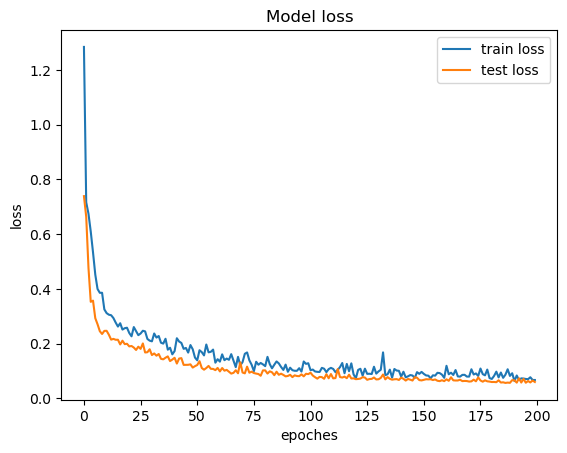

In [19]:
import matplotlib.pyplot as plt
# plot the loss curves
print("train_losses shape:",len(train_losses))
print("test_losses shape:",len(test_losses))
plt.plot(np.arange(len(train_losses)), train_losses,label="train loss")
plt.plot(np.arange(len(test_losses)), test_losses,label="test loss")
plt.legend() #显示图例
plt.xlabel('epoches')
plt.ylabel("loss")
plt.title('Model loss')
plt.show()

# Test

## Calculate mIOU

In [29]:
def testModel(dataLoader, netmodel, exp_args):
    # switch to eval mode
    netmodel.eval()
    softmax = nn.Softmax(dim=1)
    iou = 0
    for i, (input_ori, input, edge, mask) in enumerate(dataLoader):  
        input_ori_var = Variable(input_ori.cuda())
        input_var = Variable(input.cuda())
        edge_var = Variable(edge.cuda())
        mask_var = Variable(mask.cuda())
        
        # compute output: loss part1
        if exp_args.addEdge == True:
            output_mask, output_edge = netmodel(input_ori_var)
        else:
            output_mask = netmodel(input_ori_var)
            
        prob = softmax(output_mask)[0,1,:,:]
        pred = prob.data.cpu().numpy()
        pred[pred>0.5] = 1
        pred[pred<=0.5] = 0
        iou += calcIOU(pred, mask_var[0].data.cpu().numpy())
        
    print(len(dataLoader)) 
    return iou/len(dataLoader)

acc = testModel(dataLoader_test, netmodel, exp_args)
print ("mean iou: ", acc)

TypeError: 'numpy.ndarray' object is not callable

## Background blur for single image

In [22]:
def padding_img(img_ori, size=224, color=128):
    height = img_ori.shape[0]
    width = img_ori.shape[1]
    img = np.zeros((max(height, width), max(height, width), 3)) + color
    
    if (height > width):
        padding = int((height-width)/2)
        img[:, padding:padding+width, :] = img_ori
    else:
        padding = int((width-height)/2)
        img[padding:padding+height, :, :] = img_ori
        
    img = np.uint8(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)
    return np.array(img, dtype=np.float32)

def resize_padding(image, dstshape, padValue=0):
    height, width, _ = image.shape
    ratio = float(width)/height # ratio = (width:height)
    dst_width = int(min(dstshape[1]*ratio, dstshape[0]))
    dst_height = int(min(dstshape[0]/ratio, dstshape[1]))
    origin = [int((dstshape[1] - dst_height)/2), int((dstshape[0] - dst_width)/2)]
    if len(image.shape)==3:
        image_resize = cv2.resize(image, (dst_width, dst_height))
        newimage = np.zeros(shape = (dstshape[1], dstshape[0], image.shape[2]), dtype = np.uint8) + padValue
        newimage[origin[0]:origin[0]+dst_height, origin[1]:origin[1]+dst_width, :] = image_resize
        bbx = [origin[1], origin[0], origin[1]+dst_width, origin[0]+dst_height] # x1,y1,x2,y2
    else:
        image_resize = cv2.resize(image, (dst_width, dst_height),  interpolation = cv2.INTER_NEAREST)
        newimage = np.zeros(shape = (dstshape[1], dstshape[0]), dtype = np.uint8)
        newimage[origin[0]:origin[0]+height, origin[1]:origin[1]+width] = image_resize
        bbx = [origin[1], origin[0], origin[1]+dst_width, origin[0]+dst_height] # x1,y1,x2,y2
    return newimage, bbx

def generate_input(exp_args, inputs, prior=None):
    inputs_norm = Normalize_Img(inputs, scale=exp_args.img_scale, mean=exp_args.img_mean, val=exp_args.img_val)
    
    if exp_args.video == True:
        if prior is None:
            prior = np.zeros((exp_args.input_height, exp_args.input_width, 1))
            inputs_norm = np.c_[inputs_norm, prior]
        else:
            prior = prior.reshape(exp_args.input_height, exp_args.input_width, 1)
            inputs_norm = np.c_[inputs_norm, prior]
       
    inputs = np.transpose(inputs_norm, (2, 0, 1))
    return np.array(inputs, dtype=np.float32)

def pred_single(model, exp_args, img_ori, prior=None):
    model.eval()
    softmax = nn.Softmax(dim=1)
    
    in_shape = img_ori.shape
    img, bbx = resize_padding(img_ori, [exp_args.input_height, exp_args.input_width], padValue=exp_args.padding_color)
    
    in_ = generate_input(exp_args, img, prior)
    in_ = in_[np.newaxis, :, :, :]
    
    if exp_args.addEdge == True:
        output_mask, output_edge = model(Variable(torch.from_numpy(in_)).cuda())
    else:
        output_mask = model(Variable(torch.from_numpy(in_)).cuda())
    prob = softmax(output_mask)
    pred = prob.data.cpu().numpy()
    
    predimg = pred[0].transpose((1,2,0))[:,:,1]
    out = predimg[bbx[1]:bbx[3], bbx[0]:bbx[2]]
    out = cv2.resize(out, (in_shape[1], in_shape[0]))
    return out, predimg

In [30]:
print ('===========> loading model <===========')
netmodel_video = MobileNetV2(n_class=2, 
                                      useUpsample=exp_args.useUpsample, 
                                      useDeconvGroup=exp_args.useDeconvGroup, 
                                      addEdge=exp_args.addEdge, 
                                      channelRatio=1.0, 
                                      minChannel=16, 
                                      weightInit=True,
                                      video=exp_args.video).cuda()

bestModelFile = os.path.join(exp_args.model_root, 'model_best.pth.tar')
if os.path.isfile(bestModelFile):
    checkpoint_video = torch.load(bestModelFile,weights_only=False)
    netmodel_video.load_state_dict(checkpoint_video['state_dict'])
    print ("minLoss: ", checkpoint_video['minLoss'], checkpoint_video['epoch'])
    print("=> loaded checkpoint '{}' (epoch {})".format(bestModelFile, checkpoint_video['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(bestModelFile))

===========> loading model <===========
minLoss:  0.056300531723643354 187
=> loaded checkpoint 'myexp/eg1800/model_best.pth.tar' (epoch 187)


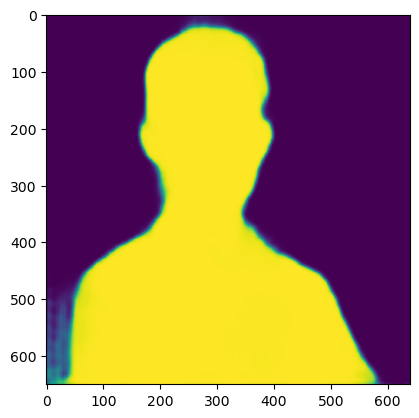

(650, 639)


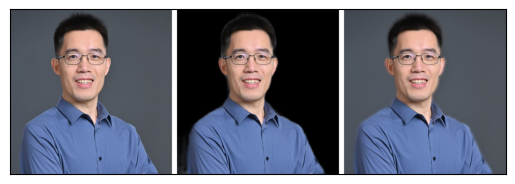

In [31]:
# =====================
img_ori = cv2.imread("E:\Python\ImageProcessing\Assignment1\Task1\images\img_1.png")
# mask_ori = cv2.imread("/home/dongx12/Data/EG1800/Labels/00457.png")

prior = None
height, width, _ = img_ori.shape

background = img_ori.copy()
background = cv2.blur(background, (17,17))

alphargb, pred = pred_single(netmodel_video, exp_args, img_ori, prior)
plt.imshow(alphargb)
plt.show()
print(alphargb.shape)

alphargb = cv2.cvtColor(alphargb, cv2.COLOR_GRAY2BGR)
result = np.uint8(img_ori * alphargb)

myImg = np.ones((height, width*3 + 40, 3)) * 255
myImg[:, :width, :] = img_ori
myImg[:, width+20:width*2+20, :] = result
myImg[:, width*2+40:, :] = np.uint8(result+background*(1-alphargb))

plt.imshow(myImg[:,:,::-1]/255)
plt.yticks([])
plt.xticks([])
plt.show()

## Video Test

In [32]:
videofile = 'data/douyu_origin.mp4'
videoCapture = cv2.VideoCapture(videofile)  
size = ((int(videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH))+20)*3, int(videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT)))  
videoWriter = cv2.VideoWriter('data/result.mp4', cv2.VideoWriter_fourcc(*'MJPG'), 20, size)  

success, frame = videoCapture.read()
cnt = 1
while success:
    if cnt == 1:
        prior = None # first frame
    else:
        prior = pred_video
    
    alpha_video, pred_video = pred_single(netmodel_video, exp_args, frame, prior)
    alpha_image, pred_image = pred_single(netmodel_video, exp_args, frame, None)
    
    def blend(frame, alpha):
        background = np.zeros(frame.shape) + [255, 255, 255]
        alphargb = cv2.cvtColor(alpha, cv2.COLOR_GRAY2BGR)
        result = np.uint8(frame * alphargb + background * (1-alphargb))
        return frame, alphargb*255, result
    
    _, alphargb_video, _ = blend(frame, alpha_video)
    _, alphargb_image, _ = blend(frame, alpha_image)
    
    padding = np.ones((frame.shape[0], 20, 3), dtype = np.uint8)*255
    result = np.uint8(np.hstack((frame, padding,
                                 alphargb_video, padding,
                                 alphargb_image, padding)))
    videoWriter.write(result)
    success, frame = videoCapture.read()
    cnt += 1
    
    if cnt % 100 == 0:
        print ("cnt: ", cnt)
    
videoWriter.release()

print("finish")

cnt:  100
cnt:  200
cnt:  300
cnt:  400
cnt:  500
cnt:  600
finish
